In [1]:
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf

import os
import pandas as pd

from functools import reduce
from datetime import datetime

from ionmob.models.deep_models import ProjectToInitialSqrtCCS, DeepRecurrentModel
from ionmob.preprocess.data import get_tf_dataset, partition_tf_dataset, split_dataset, to_tf_dataset_kmer
from ionmob.preprocess.helpers import get_sqrt_slopes_and_intercepts, sequence_to_tokens, fit_tokenizer
from ionmob.preprocess.helpers import tokenizer_to_json, tokenizer_from_json
from ionmob.preprocess.tokenization import get_index_dict, get_occurring_kmers, create_count_vectors

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
meier = pd.read_parquet('../data/Meier.parquet')
tenzer = pd.read_parquet('../data/Tenzer_unique.parquet')
tenzer_phospho = pd.read_parquet('../data/Tenzer-phospho-train.parquet')
chang = pd.read_parquet('../data/Chang_unique.parquet')

t = pd.concat([meier, tenzer, tenzer_phospho, chang])

all_pairs = get_occurring_kmers(t)
index_dict = get_index_dict(all_pairs)

In [4]:
index_dict

{('<START>', 'A'): 0,
 ('<START>', 'C-<CM>'): 1,
 ('<START>', 'D'): 2,
 ('<START>', 'E'): 3,
 ('<START>', 'F'): 4,
 ('<START>', 'G'): 5,
 ('<START>', 'H'): 6,
 ('<START>', 'I'): 7,
 ('<START>', 'K'): 8,
 ('<START>', 'L'): 9,
 ('<START>', 'M'): 10,
 ('<START>', 'M-<OX>'): 11,
 ('<START>', 'N'): 12,
 ('<START>', 'P'): 13,
 ('<START>', 'Q'): 14,
 ('<START>', 'R'): 15,
 ('<START>', 'S'): 16,
 ('<START>', 'S-<PH>'): 17,
 ('<START>', 'T'): 18,
 ('<START>', 'T-<PH>'): 19,
 ('<START>', 'V'): 20,
 ('<START>', 'W'): 21,
 ('<START>', 'Y'): 22,
 ('<START>', 'Y-<PH>'): 23,
 ('<START>-<AC>', 'A'): 24,
 ('<START>-<AC>', 'C-<CM>'): 25,
 ('<START>-<AC>', 'D'): 26,
 ('<START>-<AC>', 'E'): 27,
 ('<START>-<AC>', 'F'): 28,
 ('<START>-<AC>', 'G'): 29,
 ('<START>-<AC>', 'H'): 30,
 ('<START>-<AC>', 'I'): 31,
 ('<START>-<AC>', 'K'): 32,
 ('<START>-<AC>', 'L'): 33,
 ('<START>-<AC>', 'M'): 34,
 ('<START>-<AC>', 'M-<OX>'): 35,
 ('<START>-<AC>', 'N'): 36,
 ('<START>-<AC>', 'P'): 37,
 ('<START>-<AC>', 'Q'): 38,
 ('

In [5]:
meier['tuple-counts'] = create_count_vectors(meier, index_dict)
tenzer['tuple-counts'] = create_count_vectors(tenzer, index_dict)
tenzer_phospho['tuple-counts'] = create_count_vectors(tenzer_phospho, index_dict)
chang['tuple-counts'] = create_count_vectors(chang, index_dict)

In [6]:
phos_train, phos_valid, phos_test = split_dataset(tenzer_phospho)
train = pd.concat([meier, phos_train])
valid = pd.concat([tenzer, phos_valid])
test = pd.concat([chang, phos_test])

In [7]:
slopes, intercepts = get_sqrt_slopes_and_intercepts(t.mz.values, t.charge.values, t.ccs.values)

In [8]:
tf_train = to_tf_dataset_kmer(train.mz, train.charge, train['tuple-counts'].values, train.ccs, batch=False)
tf_valid = to_tf_dataset_kmer(valid.mz, valid.charge, valid['tuple-counts'].values, valid.ccs)
tf_test = to_tf_dataset_kmer(test.mz, test.charge, test['tuple-counts'].values, test.ccs)

tf_train = tf_train.shuffle(train.shape[0]).batch(2048)

In [13]:
from ionmob.models.deep_models import KmerNet

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='training/rnn/checkpoint',
    monitor='val_output_1_loss',
    save_best_only=True,
    mode='min'
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename='training/rnn/training.csv',
    separator=',',
    append=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_output_1_loss',
    factor=1e-1,
    patience=3,
    monde='auto',
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-7
)

cbs = [early_stopper, reduce_lr] # checkpoint, csv_logger, tensorboard_callback

model = KmerNet(
    slopes,
    intercepts
)

model.build([(None, 1), (None, 4), (None, len(index_dict))])

model.compile(loss=tf.keras.losses.MeanAbsoluteError(), loss_weights=[1.],
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mae', 'mean_absolute_percentage_error'])

In [14]:
history = model.fit(tf_train, validation_data=tf_valid, 
                    epochs=15, verbose=True, callbacks=cbs)

Epoch 1/15
376/376 [==============================] - 9s 16ms/step - loss: 13.3207 - mae: 13.2282 - mean_absolute_percentage_error: 2.8497 - val_loss: 12.9170 - val_mae: 12.8278 - val_mean_absolute_percentage_error: 2.5615 - lr: 0.0010
Epoch 2/15
376/376 [==============================] - 7s 15ms/step - loss: 11.7153 - mae: 11.6290 - mean_absolute_percentage_error: 2.2828 - val_loss: 12.9326 - val_mae: 12.8489 - val_mean_absolute_percentage_error: 2.5597 - lr: 0.0010
Epoch 3/15
376/376 [==============================] - 7s 15ms/step - loss: 11.5911 - mae: 11.5098 - mean_absolute_percentage_error: 2.2549 - val_loss: 12.9854 - val_mae: 12.9062 - val_mean_absolute_percentage_error: 2.5629 - lr: 0.0010
Epoch 4/15
376/376 [==============================] - 7s 15ms/step - loss: 11.5393 - mae: 11.4619 - mean_absolute_percentage_error: 2.2441 - val_loss: 12.9597 - val_mae: 12.8843 - val_mean_absolute_percentage_error: 2.5622 - lr: 0.0010
Epoch 5/15
376/376 [==============================] - 7s

376/376 [==============================] - 7s 14ms/step - loss: 11.4378 - mae: 11.3799 - mean_absolute_percentage_error: 2.2247 - val_loss: 12.9333 - val_mae: 12.8764 - val_mean_absolute_percentage_error: 2.5662 - lr: 0.0010
Epoch 12/15
376/376 [==============================] - 7s 14ms/step - loss: 11.4349 - mae: 11.3789 - mean_absolute_percentage_error: 2.2244 - val_loss: 13.0373 - val_mae: 12.9819 - val_mean_absolute_percentage_error: 2.5854 - lr: 0.0010
Epoch 13/15
376/376 [==============================] - 7s 15ms/step - loss: 11.4247 - mae: 11.3702 - mean_absolute_percentage_error: 2.2222 - val_loss: 12.9442 - val_mae: 12.8909 - val_mean_absolute_percentage_error: 2.5674 - lr: 0.0010
Epoch 14/15
376/376 [==============================] - 7s 15ms/step - loss: 11.4199 - mae: 11.3673 - mean_absolute_percentage_error: 2.2218 - val_loss: 12.9501 - val_mae: 12.8981 - val_mean_absolute_percentage_error: 2.5659 - lr: 0.0010
Epoch 15/15
376/376 [==============================] - 7s 15ms/s

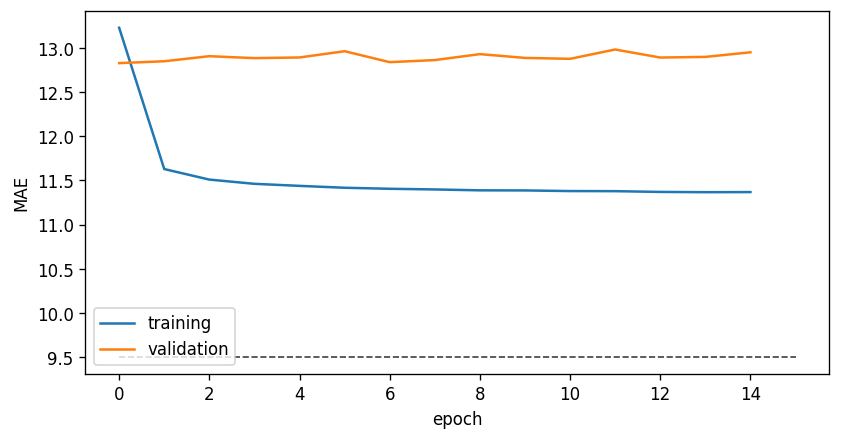

In [15]:
# plot training and validation loss 
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(history.history['mae'], label='training')
plt.plot(history.history['val_mae'], label='validation')
plt.hlines(9.5, xmin=0, xmax=len(history.history['mae']), linestyles='dashed', color='black', linewidth=1, alpha=.75)
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [16]:
model.evaluate(tf_train)

376/376 [==============================] - 8s 15ms/step - loss: 11.3826 - mae: 11.3315 - mean_absolute_percentage_error: 2.2102


[11.382563591003418, 11.331461906433105, 2.21016001701355]

In [17]:
ccs = model.predict(tf_valid)
valid['ccs_predicted'] = ccs

20/20 [==============================] - 0s 11ms/step


In [ ]:
model.save('../pretrained-models/DeepTwoMerModel/', save_format='tf')

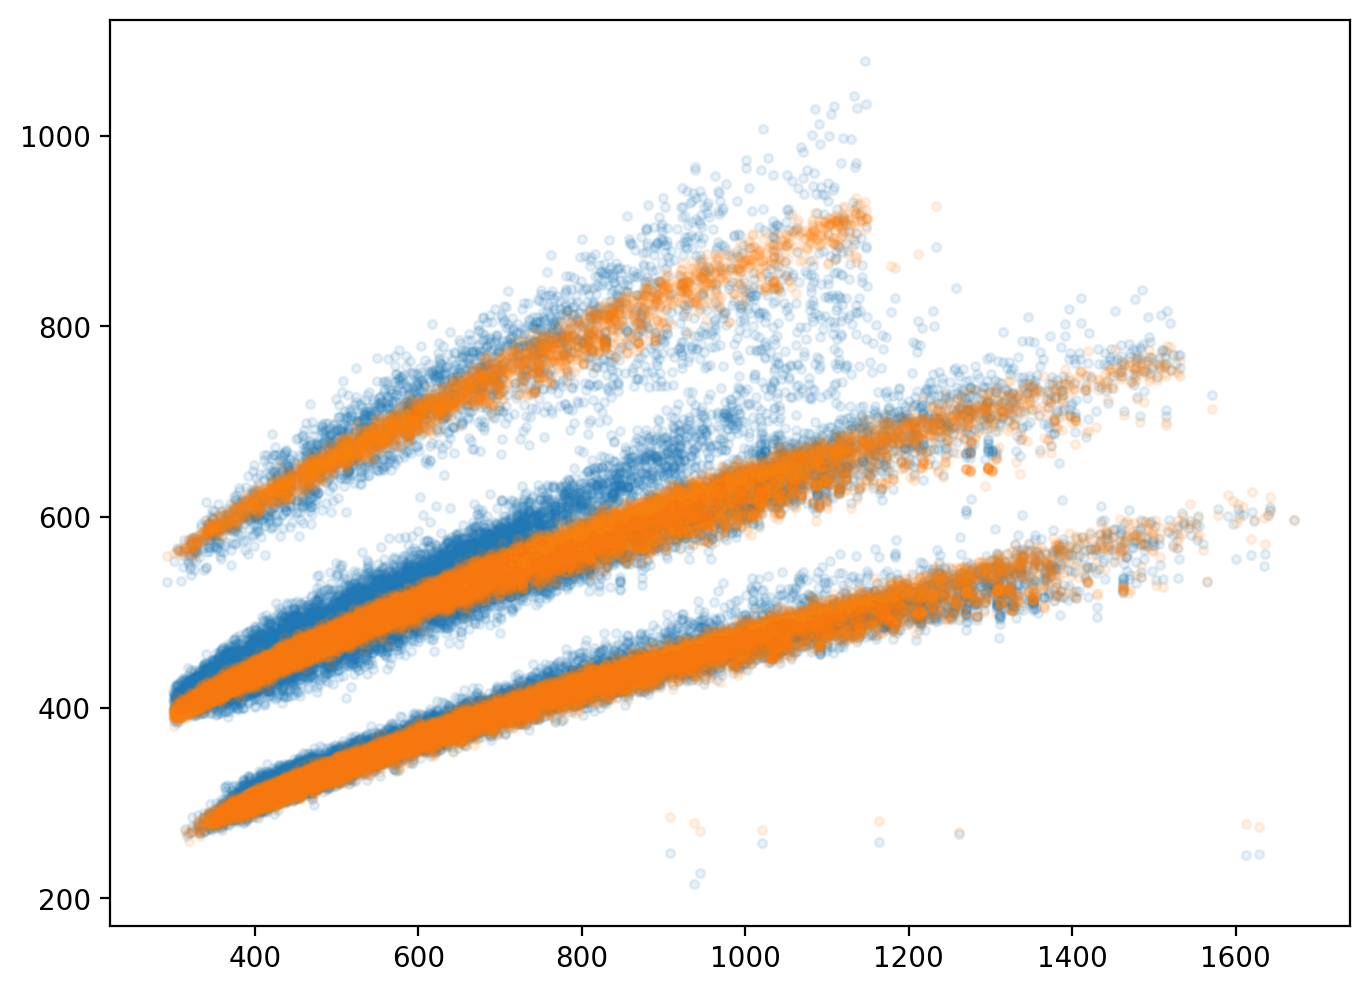

In [18]:
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(valid.mz, valid.ccs, alpha=.1, s=10)
plt.scatter(valid.mz, valid.ccs_predicted, alpha=.1, s=10)
plt.show()